In [3]:
import sys
import networkx as nx
import numpy as np

# Necessary to import from sibling directory
sys.path.append("..")


from pymdb import (
    MDBClient,
    TrainGraphLoader,
    EvalGraphLoader,
    SamplingGraphLoader,
    Sampler,
)


In [66]:
def generate_graph(
    num_nodes: int,
    num_edges: int,
    num_node_feat: int,
):
    # In-memory graph
    graph = nx.gnm_random_graph(num_nodes, num_edges)

    node_label = dict(enumerate(np.random.randint(0, 2, num_nodes)))
    nx.set_node_attributes(graph, node_label, "label")

    node_feat = dict(enumerate(np.random.rand(num_nodes, num_node_feat)))
    nx.set_node_attributes(graph, node_feat, "feat")

    # On-disk MillenniumDB graph
    graph_fname = f"G_n{num_nodes}_e{num_edges}_f{num_node_feat}.milldb"
    with open(graph_fname, "w") as f:
        for node in graph.nodes:
            f.write(
                f"N{node} :L{graph.nodes[node]['label']} \"feat\":{graph.nodes[node]['feat']}\n"
            )

    return graph


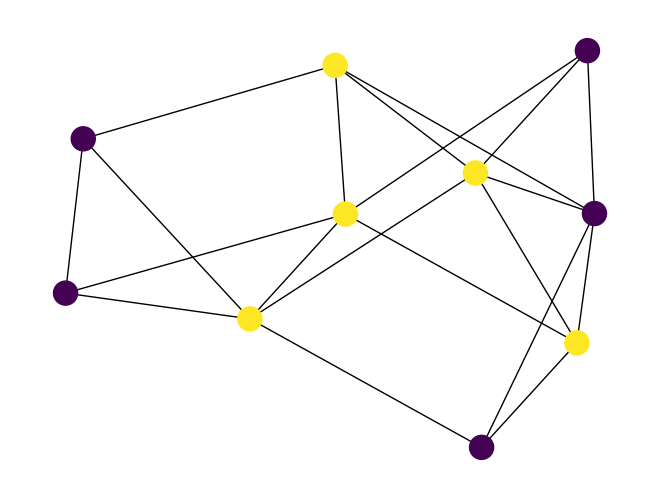

In [64]:
graph = generate_graph(10, 20, 5)
nx.draw(graph, node_color=list(nx.get_node_attributes(graph, "label").values()))
